In [1]:
from lib_util import utils, audio_functions as af, plot
import soundfile as sf
import pandas as pd
import numpy as np
import os
import librosa
import librosa.feature
from tqdm import tqdm
from random import randint
import yaml
from random import randint
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split


%load_ext autoreload
%autoreload 2
%matplotlib inline

2023-01-24 14:16:04.725703: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Preprocessing of the audio files
Perform some steps to preprocess audio files and convert them into a feature matrix.  
Our goal is to achieve the following for the raw input:
 - slice audio to 3s unit length snippets (zero-padded if shorter)
 - convert track to mono audio
 - downsample audio files to 16kBit  

These raw features will be fed into our `transformer` models.  
Afterwards, we additionally create melspectograms, which will be used by our `Short Chunk CNN` and `RNN` model.
## Audio format conversion
Since python libraries work best with WAV audio format instead of MP3, we perform a conversion of all audio files.  
Audio format conversion (from mp3 to wav) has been done before using `convert.py` in the `lib_util` folder. The converted files have been stored in `wav_data` folder.
## Preprocess converted WAV files
### Read in the audio data from the directory structure
Read in the data and store the audio content together with the directory path. The directory path is needed to extract the associatated class labels later.  
For iterating over the files a generator object is used that yields the filenames one by one, which are loaded as audio files by the `soundfile` module afterwards.

In [2]:
loaded_audio_files, dirs = zip(*[ (sf.read(audio_file_name, dtype='float32'), os.path.dirname(audio_file_name)) for audio_file_name in utils.audio_file_iterator()])

Processing genre directory '09 Disco Funk'
   Processed 298 files          
Processing genre directory '12 Chinese Traditional'
   Processed 300 files          
Processing genre directory '15 Reggaeton Pop'
   Processed 322 files          
Processing genre directory '06 Deep House'
   Processed 360 files          
Processing genre directory 'Keyboard Collection'
   Processed 164 files          


### Read in config file
The `yaml` config file contains basic parametrization. The files are stored in `configs` folder. This has the benefit to have an overview of the parameters in on small file.

In [3]:
config = utils.get_config('preprocess')

### One Hot Encoding
Use the previously obtained directory names to identify the name of the classes and encode the feature labels using a One-Hot-Encoding.

In [6]:
from sklearn.preprocessing import OneHotEncoder

class_idx = 0
# remove leading directory name
sliced_dir_names = list(map(lambda s: s.replace('wav_data\\', ''), dirs))

ohe = OneHotEncoder()
ohe_labels = ohe.fit_transform(np.array(sliced_dir_names).reshape(-1, 1))

cats = ohe.categories_[0]
print("Categories ({n}):".format(n=len(cats)))
[print("   ", cat) for cat in cats]

ohe_labels_array = ohe_labels.toarray()

Categories (5):
    wav_data/06 Deep House
    wav_data/09 Disco Funk
    wav_data/12 Chinese Traditional
    wav_data/15 Reggaeton Pop
    wav_data/Keyboard Collection


### Perform slicing to unit length on raw data

Since we dealt with small chunk datasamples, all audio files are cut into a unit time length and stored in a list, where each list elements is a tuple, consisting of a 3-second audio snippet and its samplerate.  
Slicing is performed to have no data loss, meaning that samples are cut several times in multiples of 3 seconds, with the last sample being zero-padded.

In [8]:
# Retrieve parameters  from config
unit_length = config['unit_length_ms']
downsample_rate = config['downsample_rate']

to_multi_slices = lambda t: (af.multi_slice_to_length(t[0], t[1], unit_length), t[1])

unit_length_audio = tqdm(map(to_multi_slices, loaded_audio_files))
unit_length_audio, sr = zip(*unit_length_audio)

# needed to extend the label vector later accordingly
appended_slice_lengths = [len(u) for u in unit_length_audio]

unit_length_audio = [item for sublist in unit_length_audio for item in sublist]

print("Number of unit length samples:", len(unit_length_audio))
assert sum(appended_slice_lengths) == len(unit_length_audio)

1444it [00:02, 634.47it/s]

Number of unit length samples: 4068


Append the label vector according to the appended feature matrix, since we created additional samples by using.  
Since some of the features has been duplicated because of the slicing to unit length, the label vector has to be extended too.

In [9]:
ohe_labels_array_extended = ohe_labels_array

offset = 0

for idx, append_size in enumerate(appended_slice_lengths):
    if append_size == 1:
        continue
    to_insert = np.tile(ohe_labels_array[idx, :], (append_size-1, 1))
    ohe_labels_array_extended = np.insert(ohe_labels_array_extended, idx+1+offset, to_insert, axis=0)
    offset += append_size-1

n_samples = ohe_labels_array_extended.shape[0]
print(n_samples)

# check dimensions
assert sum(appended_slice_lengths) == ohe_labels_array_extended.shape[0]

4068


Save extended label vector and the category mapping to `data` folder for later use

In [10]:
import json

np.save('data/labels.npy', ohe_labels_array_extended)

cats_dict = {}
for i, c in enumerate(cats):
    cats_dict[c.removeprefix('wav_data/')] = i

with open('data/class_label_index_mapping.json', 'w') as f:
    json.dump(cats_dict, f, indent=4)

### Perform further preprocessing
After having unit length slices, compress audio files to mono audio (since we don't expect stereo tracks will give us additional information and will only complicate training process and use more disc space).  
For the `transformer` models, we resample the audio files to `16kHz`.

In [11]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])
resample = lambda t : (af.resample(t[0], t[1], downsample_rate), t[1])

# define pipeline
preprocessing_steps = [
    to_mono,
    resample
]

features_preprocessed = unit_length_audio
for step in preprocessing_steps:
    features_preprocessed = map(step, features_preprocessed)

perform preprocessing from generator-pipline defined before and extract the features as an numpy-array

In [12]:
features, _ = zip(*tqdm(features_preprocessed, total=n_samples))
feature_array = np.vstack(features)

4068it [10:21,  6.55it/s]


### Store the data
Save the data in numpy format  
Summary:
- samples of `3s` length
- sample rate of `16kHz`
- mono audio
- samples whose length was above 3 seconds were sliced into multiple snippets, with the last snippet being `zero-padded` in the end

For saving the data we cutted the matrix. The reason was that we wanted to upload the files to `GitHub`, which only supports files of maximum size `50MB`. The files, that were saved using `save_numpy_array_sliced` from `lib_util/utils` modul, can be loaded again using `load_sliced_numpy_array`. An convenient test function for that procedure is also provided in the module.

In [13]:
print("Feature array uses {s:.2f} MB of disc space".format(s=feature_array.nbytes/1024/1024))

utils.save_numpy_array_sliced('preprocessed_data', feature_array)

Feature array uses 744.87 MB of disc space
Saved file to slices preprocessed_data
   saved slice 001 to  preprocessed_data_001
   saved slice 002 to  preprocessed_data_002
   saved slice 003 to  preprocessed_data_003
   saved slice 004 to  preprocessed_data_004
   saved slice 005 to  preprocessed_data_005
   saved slice 006 to  preprocessed_data_006
   saved slice 007 to  preprocessed_data_007
   saved slice 008 to  preprocessed_data_008
   saved slice 009 to  preprocessed_data_009


9

### Visualization of preprocessde raw data  
To visualize our preprocessing, a random sample has been plotted.  
First, reload the previously stored file with the stored feature arrays.

In [11]:
feature_array = utils.load_sliced_numpy_array('preprocessed_data')

Load slice from file preprocessed_data_001.npy
Load slice from file preprocessed_data_002.npy
Load slice from file preprocessed_data_003.npy
Load slice from file preprocessed_data_004.npy
Load slice from file preprocessed_data_005.npy
Load slice from file preprocessed_data_006.npy
Load slice from file preprocessed_data_007.npy
Load slice from file preprocessed_data_008.npy
Load slice from file preprocessed_data_009.npy
Loaded 9 files as slices, resulting shape: (4068, 48000)
(4068, 48000)


Plot a random example of a waveform from the preprocessed data to verify the preprocessing steps.  
We see the mono track with 3 second length. Rerunning the cell will pick another random sample.

Plot audio sample 1479
Dimensions: (48000,)


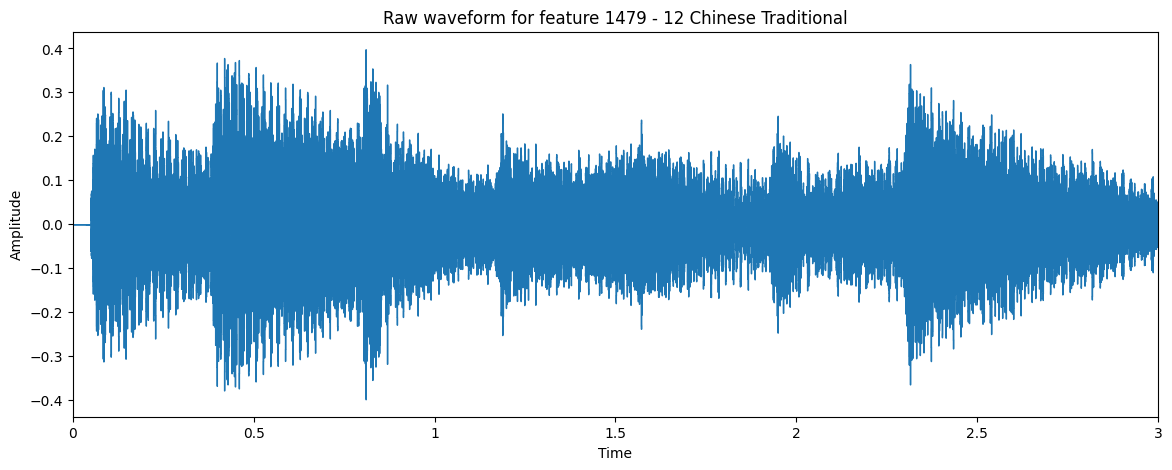

In [28]:
x = randint(0, feature_array.shape[0]-1)

random_feature = feature_array[x, :]

labels_to_id = utils.get_class_mapping()
id_to_labels = {}
for key in labels_to_id:
    id_to_labels[labels_to_id[key]] = key

print("Plot audio sample", x)
fig, ax = plot.plot_waveform(random_feature, downsample_rate)
ax.set_title(f'Raw waveform for feature {x} - {id_to_labels[np.argmax(labels[x])]}')
ax.set_xlim([0, 3])
ax.set_ylabel('Amplitude')
fig.savefig('Plots/example_wav_plot.png')

print("Dimensions:", random_feature.shape)

# Check for correct sample rate, length and for mono-track
assert random_feature.shape[0] == unit_length*downsample_rate/1000 and len(random_feature.shape) == 1

## Compute the melspectogram from the features
For our `RNN` and `SCCNN` model, we compute the `melspectogram` as features, which is a timeseries of frequency representations of a specified windows size.  

![Block diagram melspec](images/block_diagram.png "Block diagram for melspec creation")  
(from https://www.researchgate.net/publication/320733074_Novel_Phase_Encoded_Mel_Filterbank_Energies_for_Environmental_Sound_Classification)  

First, we again use mono channel to make it compatible with the library:

In [ ]:
to_mono = lambda t : (af.to_mono_channel(t[0]), t[1])

print("Convert to mono channel")
mono_unit_length_audio, s_rates = zip(*tqdm(map(to_mono, unit_length_audio)))
print("Stack to a single matrix")
mono_unit_length_audio_array = np.vstack(mono_unit_length_audio)

print(mono_unit_length_audio_array.shape)

Further, `librosa` is used to extract the melspectograms in `dB`.  
Again, we stack the flattened results to a single matrix. Later, we can use the `n_mels` parameter (vertical dimension of melspec matrix) from the `preprocess config file` to recreate the 2D-shape if needed.

In [15]:
sample_rate = s_rates[0]
n_mels = config['melspectogram']['n_mels']
f_max = sample_rate/2
hop_length = config['melspectogram']['hop_length']

get_melspectogram = lambda t: librosa.power_to_db(librosa.feature.melspectrogram(y=t, sr=sample_rate, n_mels=n_mels, fmax=f_max, hop_length=hop_length)).flatten()

print("Compute the melspectogram")
features_spectogram = list(tqdm(map(get_melspectogram, mono_unit_length_audio_array)))

print("Stack to a single matrix")
features_spectogram = np.vstack(features_spectogram)

print("Shape of the feature vector:", features_spectogram.shape)

Compute the melspectogram


4068it [00:44, 90.97it/s] 


Stack to a single matrix
Shape of the feature vector: (4068, 33152)


Save the melspectogram arrays separately, again with the `save_numpy_array_sliced` function due to `GitHub's` large file restriction.

In [22]:
print("Feature array uses {s:.2f} MB of disc space".format(s=features_spectogram.nbytes/1024/1024))

utils.save_numpy_array_sliced('melspec_features', features_spectogram, max_size_mb=45)

Feature array uses 514.46 MB of disc space
Saved file to slices melspec_features
   saved slice 001 to  melspec_features_001
   saved slice 002 to  melspec_features_002
   saved slice 003 to  melspec_features_003
   saved slice 004 to  melspec_features_004
   saved slice 005 to  melspec_features_005
   saved slice 006 to  melspec_features_006
   saved slice 007 to  melspec_features_007
   saved slice 008 to  melspec_features_008
   saved slice 009 to  melspec_features_009
   saved slice 010 to  melspec_features_010
   saved slice 011 to  melspec_features_011
   saved slice 012 to  melspec_features_012


### Load and validate
Load the melspectogram features and plot an example, to validate our output. Rerunning this cell will plot another (random) example.

Load slice from file melspec_features_001.npy
Load slice from file melspec_features_002.npy
Load slice from file melspec_features_003.npy
Load slice from file melspec_features_004.npy
Load slice from file melspec_features_005.npy
Load slice from file melspec_features_006.npy
Load slice from file melspec_features_007.npy
Load slice from file melspec_features_008.npy
Load slice from file melspec_features_009.npy
Load slice from file melspec_features_010.npy
Load slice from file melspec_features_011.npy
Load slice from file melspec_features_012.npy
Loaded 12 files as slices, resulting shape: (4068, 33152)
Plot melspec for feature 1479 (12 Chinese Traditional):
(128, 259)



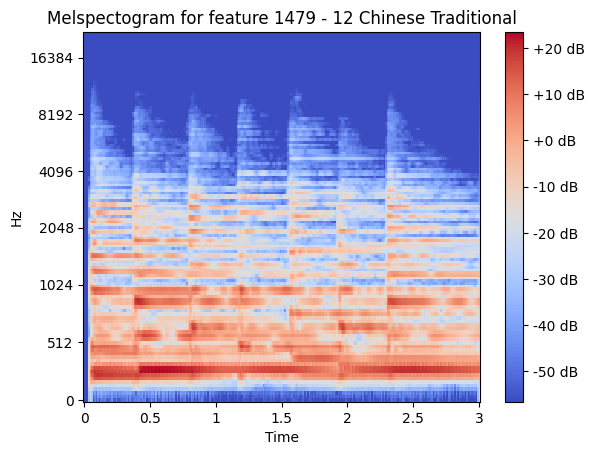

In [26]:
config = utils.get_config('preprocess')

features_spectogram = utils.load_sliced_numpy_array('melspec_features')
labels = np.load('data/labels.npy')

n_mels = config['melspectogram']['n_mels']

x = randint(0, features_spectogram.shape[0]-1)

labels_to_id = utils.get_class_mapping()
id_to_labels = {}
for key in labels_to_id:
    id_to_labels[labels_to_id[key]] = key

print(f'Plot melspec for feature {x} ({id_to_labels[np.argmax(labels[x])]}):')

feature_to_plot = features_spectogram[x, :].reshape(n_mels, -1)
print(feature_to_plot.shape)
print()
fig, ax = plot.plot_melspectogram(feature_to_plot, config['original_sample_rate'], fmax=config['original_sample_rate']/2, calculate_db=False, save_fig=False)
ax.set_title(f'Melspectogram for feature {x} - {id_to_labels[np.argmax(labels[x])]}')
fig.savefig('Plots/example_melspecogram.png')

## Test data distribution
The data, which will be split into `train`, `validation` and `test` according to the specified parameters in the `config` files (each model config can specify their own data splits).  
For all models, we use 
- 70% train data
- 15% validation data
- 15% test data

To see, what metric might be suitable for our models, we check on how our lables are distributed in `train` and `validation` sets.

Relative distribution of labels in train set:
    {'Keyboard Collection': 0.15, '15 Reggaeton Pop': 0.23, '12 Chinese Traditional': 0.24, '09 Disco Funk': 0.16, '06 Deep House': 0.21}
Relative distribution of labels in validation set:
    {'Keyboard Collection': 0.15, '15 Reggaeton Pop': 0.24, '12 Chinese Traditional': 0.22, '09 Disco Funk': 0.18, '06 Deep House': 0.21}


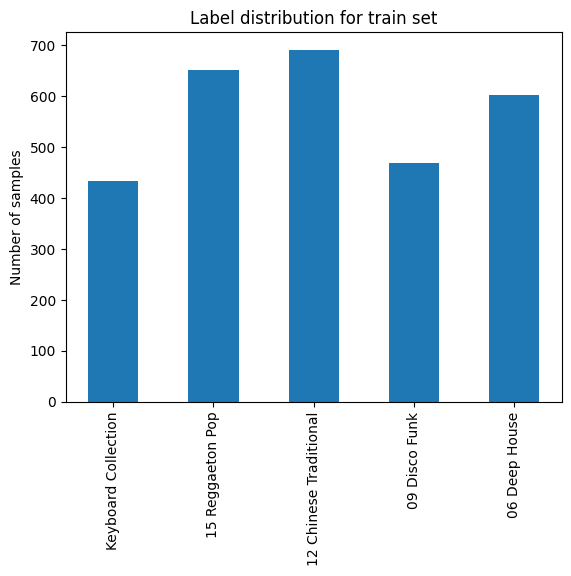

In [4]:
labels = np.load('data/labels.npy')
lab_train, lab_val_test = train_test_split(labels, train_size=config['train_set_size'], random_state=config['random_state'])
lab_val, _              = train_test_split(lab_val_test, test_size=(config['val_set_size']/(1-config['train_set_size'])), shuffle=False)

distr_train = utils.get_label_distribution(lab_train)
distr_val   = utils.get_label_distribution(lab_val)

fig, ax = plt.subplots()
plt.title('Label distribution for train set')
plt.xticks(rotation=90)
plt.ylabel('Number of samples')
ax.bar(range(5), [distr_train[key] for key in distr_train], tick_label=[key for key in distr_train], width=0.5)

fig.savefig('Plots/label_distribution.png', bbox_inches='tight')

# Print normalized (relative) distribution for train and val for comparison
print("Relative distribution of labels in train set:\n   ", utils.get_label_distribution(lab_train, as_normalized=True))
print("Relative distribution of labels in validation set:\n   ", utils.get_label_distribution(lab_val, as_normalized=True))


We see, that the relative distribution for the labels are almost equal in `train` and `validation` sets. Looking at the bar plot, we decided for using `weighted f1-score` as the final model comparison metric, since the distribution of labels in the `training` data is skewed. 